In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import re
#preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix,roc_curve,classification_report

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [2]:
df_train=pd.read_csv('/Users/draculalemon/Downloads/emotional_data_nlp/train.txt',
                     delimiter=';',names=['text','labels'])
df_val=pd.read_csv('/Users/draculalemon/Downloads/emotional_data_nlp/val.txt',
                   delimiter=';',names=['text','labels'])

In [3]:
df_train.head()

,text,labels
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
df_val.head()

,text,labels
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [5]:
#concatenating the dataframe as we will be using only test data set, for evaluation
df=pd.concat([df_train,df_val],axis=0)

In [6]:
df.reset_index(inplace=True,drop=True) #resetting the index

In [7]:
df

,text,labels
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
17995,im having ssa examination tomorrow in the morn...,sadness
17996,i constantly worry about their fight against n...,joy
17997,i feel its important to share this info for th...,joy
17998,i truly feel that if you are passionate enough...,joy


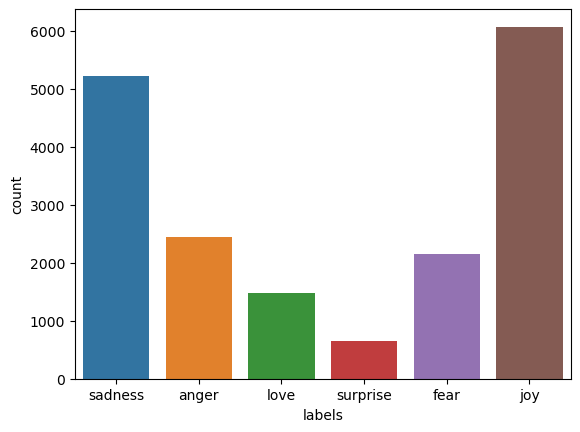

In [8]:
sns.countplot(df.labels); #plotting the data labels

we will work with only two type of sentiments positive and negative,
so we will merge the data label



Positive = joy,love, surprise 




Negative = anger,sadness,fear

In [9]:
def custom_val(df):#custom function to change the name of category values into numericals labels
    df.replace('surprise',value=1,inplace=True)
    df.replace('love',value=1,inplace=True)
    df.replace('joy',value=1,inplace=True)
    df.replace('fear',value=0,inplace=True)
    df.replace('anger',value=0,inplace=True)
    df.replace('sadness',value=0,inplace=True)
    

In [10]:
custom_val(df['labels'])

<AxesSubplot:xlabel='labels', ylabel='count'>

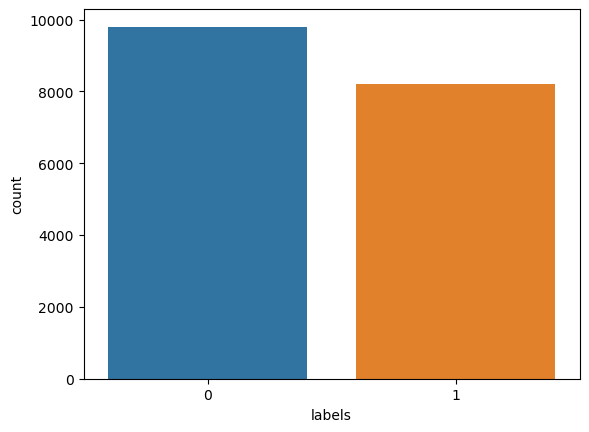

In [11]:
#plotting the number of postive or negative
sns.countplot(df.labels)

As we can see that the number of negative is little more than the positive.

In [12]:
lemm=WordNetLemmatizer() # using lammetizing, because lemmetizig is more accurate than 
# stemmer and it also preserve the context of the word, but it is slower than stemmer.

In [13]:
# a custom function to transform and removing stop words and other non related features in the senteance.
def text_transfer(df_col):
    corpus=[] # empty list to store all the process word and later to be used in model
    for item in df_col:
        new_item=re.sub('[^a-zA-z]',' ', str(item))
        new_item=new_item.lower()
        new_item=new_item.split()
        new_item=[lemm.lemmatize(word)for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [14]:
corpus=text_transfer(df['text'])

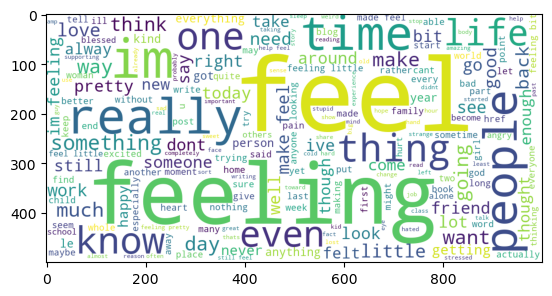

In [15]:
# plotting word cloud to see the most frequent words in the sentance.
word_cloud=''
for row in corpus:
    for word in row:
        word_cloud+=' '.join(word)
wordclouds=WordCloud(width=1000,height=500,background_color='white',min_font_size=10).generate(word_cloud)
plt.imshow(wordclouds)

In [16]:
cv=CountVectorizer(ngram_range=(1,2)) # using bow
traindata=cv.fit_transform(corpus) # here we are fitting the corpus data which is already processed.
X=traindata
y=df.labels

In [17]:
rfc=RandomForestClassifier(n_estimators=500,max_depth=None,max_features='auto',boostrap=True,
                           min_samples_split=5,min_samples_leaf=1)

In [18]:
rfc.fit(X,y) #fitting the data into the model

RandomForestClassifier(max_depth=4, min_samples_split=5, n_estimators=500)

In [19]:
test_df=pd.read_csv('/Users/draculalemon/Downloads/emotional_data_nlp/test.txt',
                delimiter=';',names=['text','labels'])

In [20]:
X_test,y_test=test_df.text,test_df.labels

In [22]:
#encoding the labels into two class 0 , and 1
test_df=custom_val(y_test)
#pre-processing the text
test_corpus=text_transfer(X_test)
#converting text data into vectors
testdata=cv.transform(test_corpus)

In [23]:
#predictig the target
pred=rfc.predict(testdata)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
acc_score=accuracy_score(y_test,pred)
pre_score=precision_score(y_test,pred)
rec_score=recall_score(y_test,pred)
print('accuracy_Score ',acc_score)
print('Precission Score ',pre_score)
print('Recall_Score ',rec_score)
#printin the classification report
CP=classification_report(y_test,pred)
print(CP)

accuracy_Score  0.54
Precission Score  0.0
Recall_Score  0.0
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1080
           1       0.00      0.00      0.00       920

    accuracy                           0.54      2000
   macro avg       0.27      0.50      0.35      2000
weighted avg       0.29      0.54      0.38      2000



### Hyperparameter Tuning

In [63]:
param1={'criterion':['gini','entropy'],
      'n_estimators':[200,500,600],
      'max_depth':[5,6,7],
      'min_samples_split':[5,7,8],
      'min_samples_leaf':[2,5,10]}

In [64]:
#fitting the data into grid search 
grid_search=GridSearchCV(RandomForestClassifier(max_features='auto'),param1,cv=5,
                         return_train_score=True,verbose=5)

In [65]:
grid_search.fit(X,y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.544, test=0.544) total time=   2.6s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.544, test=0.544) total time=   2.6s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.544, test=0.545) total time=   2.6s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.544, test=0.544) total time=   2.6s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.544, test=0.544) total time=   2.6s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.5s
[CV 2/5] END criter

[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.7s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.544, test=0.544) total time=   8.0s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.544, test=0.544) total time=   8.0s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.544, test=0.544) total time=   8.1s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.544, test=0.544) total time=   8.0s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.544, test=0.544) total time=   8.0s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=7,

[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=7, n_estimators=200;, score=(train=0.544, test=0.544) total time=   2.6s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=7, n_estimators=200;, score=(train=0.545, test=0.544) total time=   2.7s
[CV 1/5] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=7, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.6s
[CV 2/5] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=7, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.4s
[CV 3/5] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=7, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.6s
[CV 4/5] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_split=7, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.6s
[CV 5/5] END criterion=gini, max_depth=5, min_samples_leaf=10, min_samples_s

[CV 3/5] END criterion=gini, max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=(train=0.544, test=0.545) total time=   9.2s
[CV 4/5] END criterion=gini, max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=(train=0.544, test=0.544) total time=   9.5s
[CV 5/5] END criterion=gini, max_depth=6, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=(train=0.544, test=0.544) total time=   9.3s
[CV 1/5] END criterion=gini, max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=(train=0.544, test=0.544) total time=   3.1s
[CV 2/5] END criterion=gini, max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=(train=0.544, test=0.545) total time=   3.1s
[CV 3/5] END criterion=gini, max_depth=6, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=(train=0.544, test=0.544) total time=   3.1s
[CV 4/5] END criterion=gini, max_depth=6, min_samples_leaf=2, min_samples_split=8,

[CV 2/5] END criterion=gini, max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=500;, score=(train=0.544, test=0.544) total time=   7.7s
[CV 3/5] END criterion=gini, max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=500;, score=(train=0.544, test=0.544) total time=   7.6s
[CV 4/5] END criterion=gini, max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=500;, score=(train=0.545, test=0.544) total time=   7.7s
[CV 5/5] END criterion=gini, max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=500;, score=(train=0.545, test=0.544) total time=   7.7s
[CV 1/5] END criterion=gini, max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=600;, score=(train=0.545, test=0.544) total time=   9.2s
[CV 2/5] END criterion=gini, max_depth=6, min_samples_leaf=5, min_samples_split=8, n_estimators=600;, score=(train=0.544, test=0.545) total time=   9.2s
[CV 3/5] END criterion=gini, max_depth=6, min_samples_leaf=5, min_samples_split=8,

[CV 1/5] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.544, test=0.545) total time=   3.5s
[CV 2/5] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.545, test=0.545) total time=   3.5s
[CV 3/5] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.545, test=0.544) total time=   3.6s
[CV 4/5] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.545, test=0.544) total time=   3.5s
[CV 5/5] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.545, test=0.545) total time=   3.6s
[CV 1/5] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.545, test=0.544) total time=   8.8s
[CV 2/5] END criterion=gini, max_depth=7, min_samples_leaf=2, min_samples_split=5,

[CV 5/5] END criterion=gini, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.545, test=0.544) total time=   8.9s
[CV 1/5] END criterion=gini, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.544, test=0.544) total time=  10.6s
[CV 2/5] END criterion=gini, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.545, test=0.545) total time=  10.6s
[CV 3/5] END criterion=gini, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.544, test=0.545) total time=  10.6s
[CV 4/5] END criterion=gini, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.545, test=0.544) total time=  10.6s
[CV 5/5] END criterion=gini, max_depth=7, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.545, test=0.544) total time=  10.6s
[CV 1/5] END criterion=gini, max_depth=7, min_samples_leaf=5, min_samples_split=7,

[CV 4/5] END criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=200;, score=(train=0.545, test=0.545) total time=   3.5s
[CV 5/5] END criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=200;, score=(train=0.545, test=0.544) total time=   3.5s
[CV 1/5] END criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=500;, score=(train=0.545, test=0.544) total time=   8.6s
[CV 2/5] END criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=500;, score=(train=0.545, test=0.545) total time=   8.7s
[CV 3/5] END criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=500;, score=(train=0.545, test=0.545) total time=   8.7s
[CV 4/5] END criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=500;, score=(train=0.544, test=0.544) total time=   8.7s
[CV 5/5] END criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_s

[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=(train=0.544, test=0.544) total time=   7.8s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=(train=0.544, test=0.544) total time=   7.8s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=(train=0.544, test=0.544) total time=   7.8s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=(train=0.544, test=0.544) total time=   7.8s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=(train=0.544, test=0.544) total time=   2.6s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=200;, score=(train=0.544, test=0.544) total time=   2.6s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=2,

[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=200;, score=(train=0.544, test=0.544) total time=   2.6s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.4s
[CV 2/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.5s
[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.5s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.5s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=5, min_samples_split=8, n_estimators=500;, score=(train=0.544, test=0.544) total time=   6.5s
[CV 1/5] END criterion=entropy, max_depth=5, min_samples_leaf=5,

[CV 3/5] END criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=8, n_estimators=600;, score=(train=0.544, test=0.544) total time=   7.7s
[CV 4/5] END criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=8, n_estimators=600;, score=(train=0.544, test=0.544) total time=   7.7s
[CV 5/5] END criterion=entropy, max_depth=5, min_samples_leaf=10, min_samples_split=8, n_estimators=600;, score=(train=0.544, test=0.544) total time=   7.7s
[CV 1/5] END criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.544, test=0.545) total time=   3.1s
[CV 2/5] END criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.545, test=0.544) total time=   3.1s
[CV 3/5] END criterion=entropy, max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.545, test=0.544) total time=   3.1s
[CV 4/5] END criterion=entropy, max_depth=6, min_samples_leaf

[CV 1/5] END criterion=entropy, max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.544, test=0.544) total time=   8.3s
[CV 2/5] END criterion=entropy, max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.544, test=0.544) total time=   8.4s
[CV 3/5] END criterion=entropy, max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.544, test=0.544) total time=   8.3s
[CV 4/5] END criterion=entropy, max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.544, test=0.544) total time=   8.3s
[CV 5/5] END criterion=entropy, max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=500;, score=(train=0.544, test=0.544) total time=   8.4s
[CV 1/5] END criterion=entropy, max_depth=6, min_samples_leaf=5, min_samples_split=5, n_estimators=600;, score=(train=0.544, test=0.544) total time=  10.0s
[CV 2/5] END criterion=entropy, max_depth=6, min_samples_leaf=5,

[CV 4/5] END criterion=entropy, max_depth=6, min_samples_leaf=10, min_samples_split=5, n_estimators=600;, score=(train=0.544, test=0.544) total time=  10.1s
[CV 5/5] END criterion=entropy, max_depth=6, min_samples_leaf=10, min_samples_split=5, n_estimators=600;, score=(train=0.545, test=0.544) total time=  10.1s
[CV 1/5] END criterion=entropy, max_depth=6, min_samples_leaf=10, min_samples_split=7, n_estimators=200;, score=(train=0.544, test=0.544) total time=   3.4s
[CV 2/5] END criterion=entropy, max_depth=6, min_samples_leaf=10, min_samples_split=7, n_estimators=200;, score=(train=0.544, test=0.544) total time=   3.4s
[CV 3/5] END criterion=entropy, max_depth=6, min_samples_leaf=10, min_samples_split=7, n_estimators=200;, score=(train=0.544, test=0.544) total time=   3.4s
[CV 4/5] END criterion=entropy, max_depth=6, min_samples_leaf=10, min_samples_split=7, n_estimators=200;, score=(train=0.544, test=0.544) total time=   3.4s
[CV 5/5] END criterion=entropy, max_depth=6, min_samples_l

[CV 2/5] END criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=(train=0.545, test=0.545) total time=   9.6s
[CV 3/5] END criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=(train=0.545, test=0.544) total time=   9.6s
[CV 4/5] END criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=(train=0.545, test=0.544) total time=   9.7s
[CV 5/5] END criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=(train=0.545, test=0.544) total time=   9.7s
[CV 1/5] END criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=(train=0.544, test=0.544) total time=  11.6s
[CV 2/5] END criterion=entropy, max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=(train=0.545, test=0.544) total time=  11.6s
[CV 3/5] END criterion=entropy, max_depth=7, min_samples_leaf=2,

[CV 5/5] END criterion=entropy, max_depth=7, min_samples_leaf=5, min_samples_split=7, n_estimators=600;, score=(train=0.545, test=0.544) total time=  11.4s
[CV 1/5] END criterion=entropy, max_depth=7, min_samples_leaf=5, min_samples_split=8, n_estimators=200;, score=(train=0.545, test=0.545) total time=   3.8s
[CV 2/5] END criterion=entropy, max_depth=7, min_samples_leaf=5, min_samples_split=8, n_estimators=200;, score=(train=0.545, test=0.545) total time=   3.8s
[CV 3/5] END criterion=entropy, max_depth=7, min_samples_leaf=5, min_samples_split=8, n_estimators=200;, score=(train=0.544, test=0.545) total time=   3.9s
[CV 4/5] END criterion=entropy, max_depth=7, min_samples_leaf=5, min_samples_split=8, n_estimators=200;, score=(train=0.544, test=0.544) total time=   3.8s
[CV 5/5] END criterion=entropy, max_depth=7, min_samples_leaf=5, min_samples_split=8, n_estimators=200;, score=(train=0.545, test=0.544) total time=   3.9s
[CV 1/5] END criterion=entropy, max_depth=7, min_samples_leaf=5,

[CV 3/5] END criterion=entropy, max_depth=7, min_samples_leaf=10, min_samples_split=8, n_estimators=500;, score=(train=0.544, test=0.544) total time=   9.2s
[CV 4/5] END criterion=entropy, max_depth=7, min_samples_leaf=10, min_samples_split=8, n_estimators=500;, score=(train=0.545, test=0.544) total time=   9.2s
[CV 5/5] END criterion=entropy, max_depth=7, min_samples_leaf=10, min_samples_split=8, n_estimators=500;, score=(train=0.545, test=0.544) total time=   9.2s
[CV 1/5] END criterion=entropy, max_depth=7, min_samples_leaf=10, min_samples_split=8, n_estimators=600;, score=(train=0.544, test=0.544) total time=  11.1s
[CV 2/5] END criterion=entropy, max_depth=7, min_samples_leaf=10, min_samples_split=8, n_estimators=600;, score=(train=0.545, test=0.544) total time=  11.0s
[CV 3/5] END criterion=entropy, max_depth=7, min_samples_leaf=10, min_samples_split=8, n_estimators=600;, score=(train=0.544, test=0.545) total time=  11.0s
[CV 4/5] END criterion=entropy, max_depth=7, min_samples_l

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 7, 8],
                         'n_estimators': [200, 500, 600]},
             return_train_score=True, verbose=5)

In [66]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 10,
 'min_samples_split': 8,
 'n_estimators': 200}

In [74]:
rfc1=RandomForestClassifier(max_depth=grid_search.best_params_['max_depth'],criterion='entropy',
                          n_estimators=grid_search.best_params_['n_estimators'],
                          min_samples_split=grid_search.best_params_['min_samples_split'],
                          min_samples_leaf=grid_search.best_params_['min_samples_leaf'])

In [75]:
rfc1.fit(X,y)

RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_leaf=10,
                       min_samples_split=8, n_estimators=200)

In [76]:
pred1=rfc1.predict(testdata)
pred1

array([0, 0, 0, ..., 0, 0, 0])

In [77]:
acc_score1=accuracy_score(y_test,pred1)
pre_score1=precision_score(y_test,pred1)
rec_score1=recall_score(y_test,pred1)
print('accuracy_Score ',acc_score1)
print('Precission Score ',pre_score1)
print('Recall_Score ',rec_score1)
#printin the classification report
CP1=classification_report(y_test,pred1)
print(CP1)

accuracy_Score  0.5405
Precission Score  1.0
Recall_Score  0.0010869565217391304
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1080
           1       1.00      0.00      0.00       920

    accuracy                           0.54      2000
   macro avg       0.77      0.50      0.35      2000
weighted avg       0.75      0.54      0.38      2000

